# An interactive exoplanet discovery tool.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Brought in via TAP API, via fetch_exoplanets.py
main_df = pd.read_csv("../data/raw/exoplanets.csv")

In [3]:
main_df.head(3)

,pl_name,pl_rade,pl_bmasse,pl_orbper,pl_eqt,st_teff,st_rad
0,HR 8799 d,13.000,3000.00,37000.000000,NaN,NaN,NaN
1,GJ 1214 b,2.270,6.43,1.580405,NaN,NaN,0.210
2,GJ 1214 b,2.678,6.55,1.580393,555.0,3026.0,0.211


In [4]:
main_df.shape

(3209, 7)

# EDA

In [5]:
main_df.isna().sum()

pl_name         0
pl_rade         0
pl_bmasse       0
pl_orbper       0
pl_eqt       1393
st_teff       466
st_rad        192
dtype: int64

With the discovery of missing feature values, most importantly stellar information, I have found it difficult to include these features with missing values based around my desire of this analysis to focus on well-characterized systems. That coupled with lacking domain knowledge, I have chosen to remove this data from the data set. This approach ensures our models learn from physically consistent and reliable data, even though it reduces the dataset size.

In [6]:
main_df.dropna(inplace=True)

In [7]:
main_df.shape

(1738, 7)

Because this project focuses on exploratory clustering rather than predictive performance, preprocessing steps were applied to the full dataset. For any supervised modeling or evaluation tasks, preprocessing would be restricted to the training data to avoid information leakage.

The first portion of this project will focus on building a KMeans model in order to attempt to locate structure within our dataset.

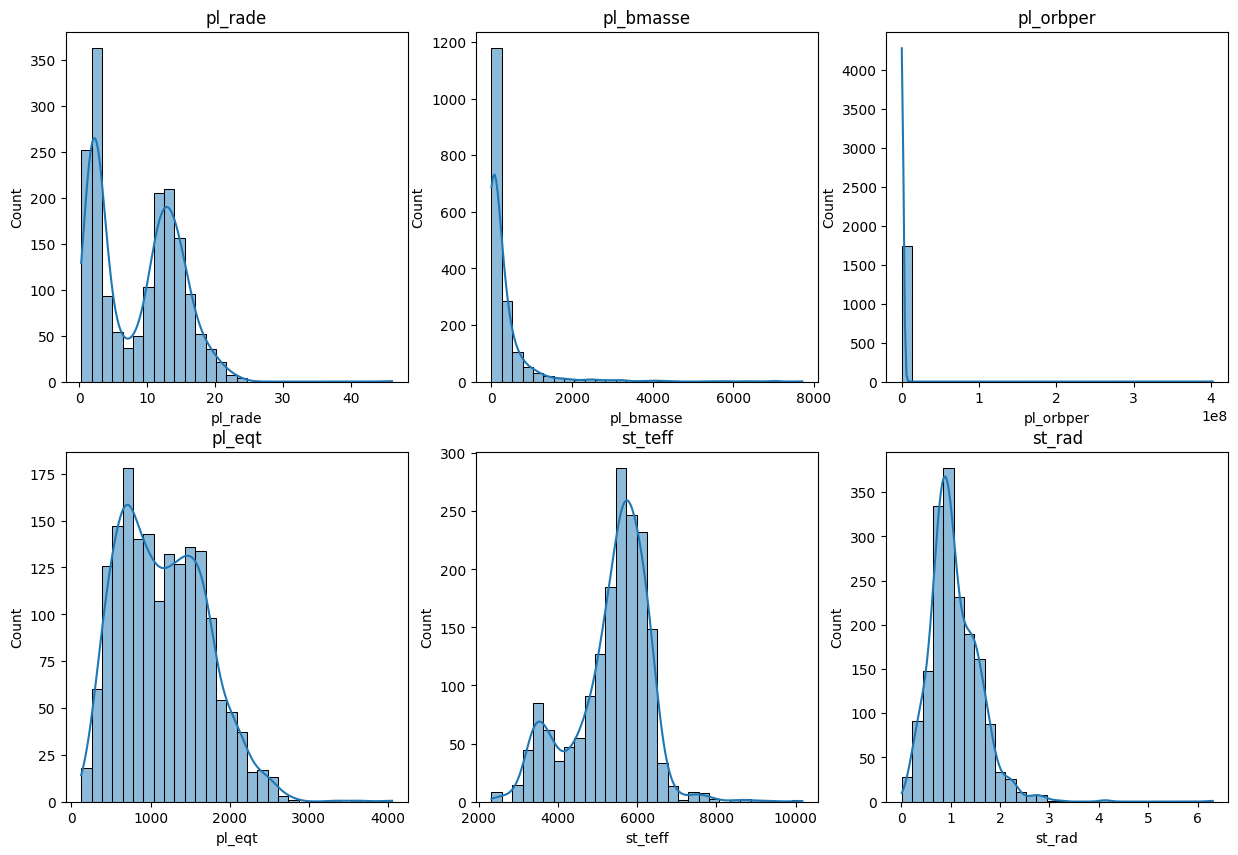

In [8]:
numeric_cols = ["pl_rade", "pl_bmasse", "pl_orbper", "pl_eqt", "st_teff", "st_rad"]

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(main_df[col], kde=True, bins=30)
    plt.title(col)
plt.show()

Strong candidates for log transformation prior to scaling for KMeans:
 - pl_rade
 - pl_bmasse
 - pl_orbper
 - st_rad

Weaker candidate:
 - pl_eqt

st_teff I will leave for now, it's a tad bimodal, may standardize prior to scaling   

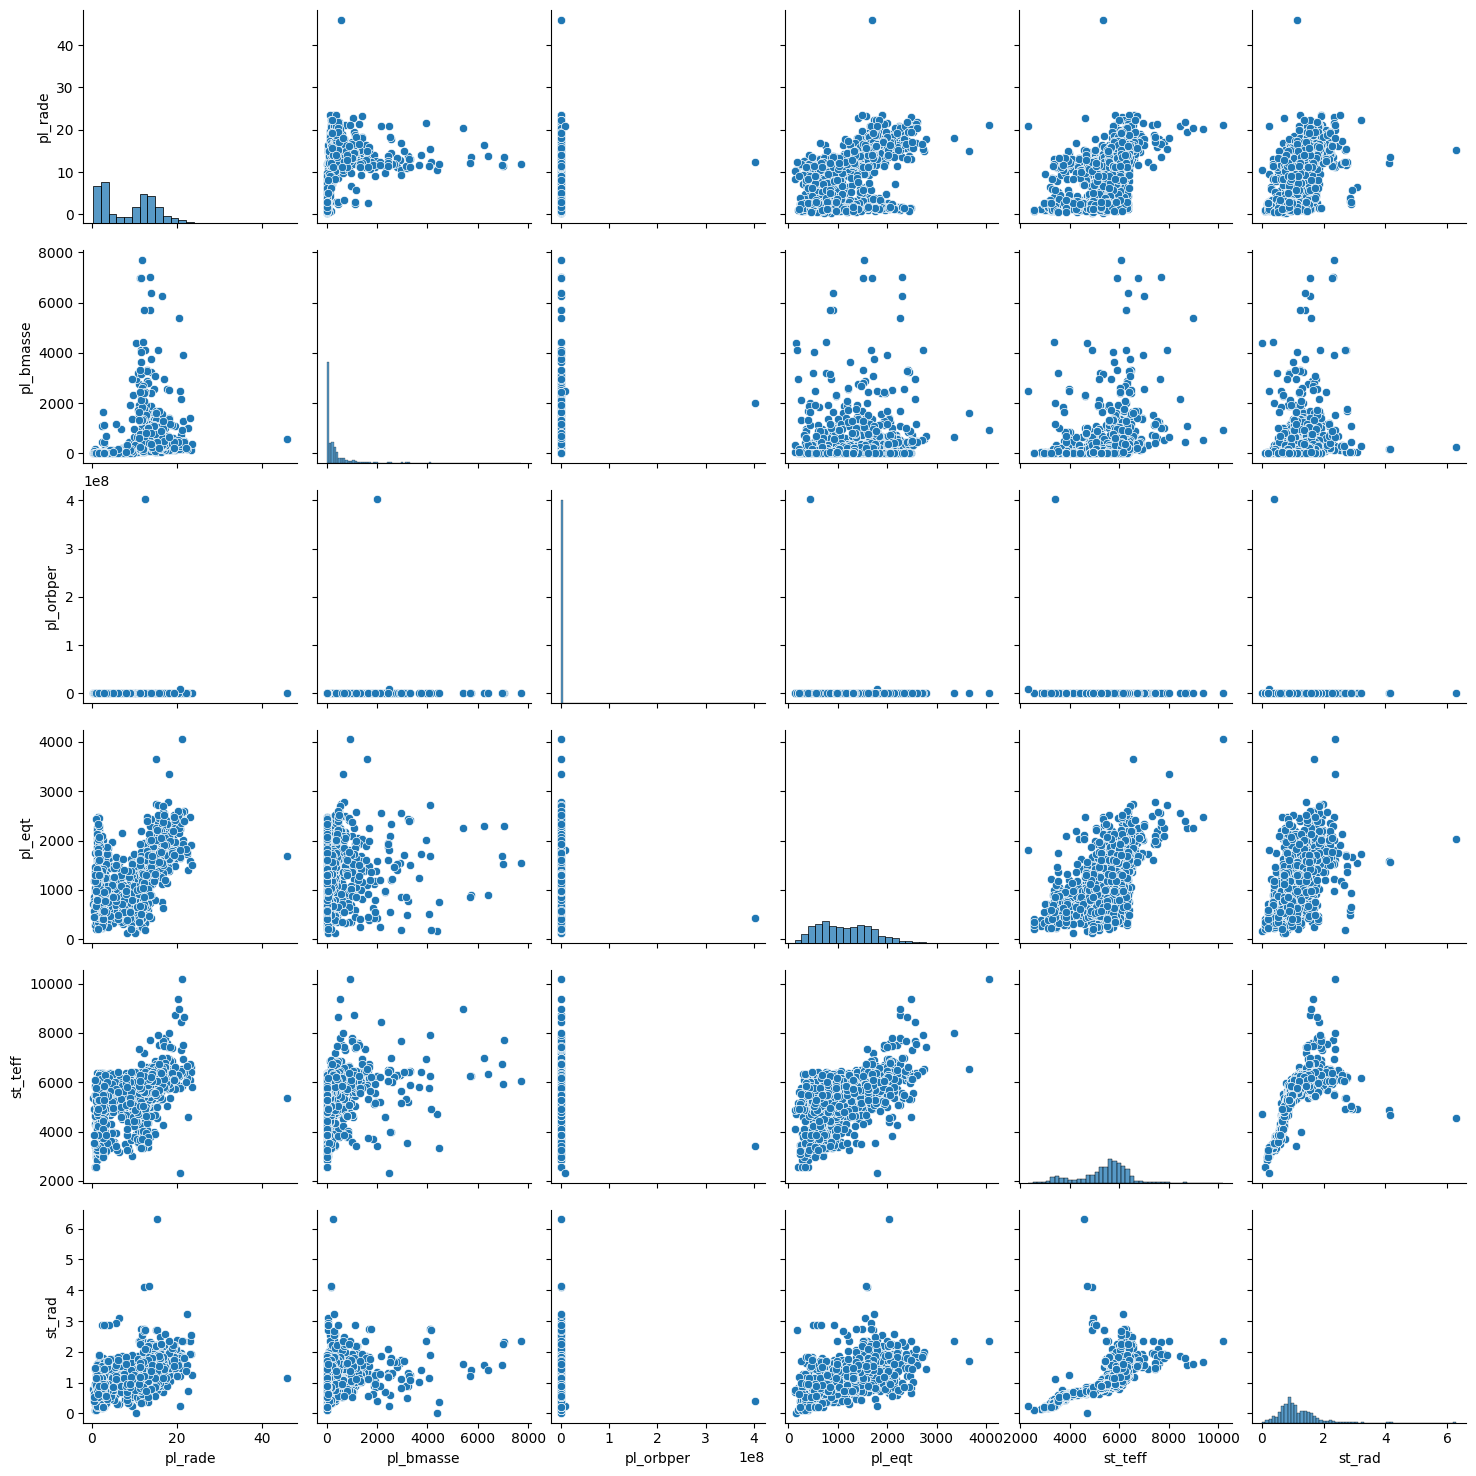

In [9]:
sns.pairplot(main_df[numeric_cols])
plt.show()

In [10]:
# Let's take the log transformation of these columns prior to 
# scaling our data for KMeans
print("Checking for 0 or negative values prior to log transformation:")
print(f"pl_rade: {main_df[main_df['pl_rade'] <= 0].count().sum()}")
print(f"pl_bmasse: {main_df[main_df['pl_bmasse'] <= 0].count().sum()}")
print(f"pl_orbper: {main_df[main_df['pl_orbper'] <= 0].count().sum()}")
print(f"st_rad: {main_df[main_df['st_rad'] <= 0].count().sum()}")

Checking for 0 or negative values prior to log transformation:
pl_rade: 0
pl_bmasse: 0
pl_orbper: 0
st_rad: 0


In [11]:
# Since no 0 or negative, continue with log transform
main_df['pl_rade'] = np.log(main_df['pl_rade'])
main_df['pl_bmasse'] = np.log(main_df['pl_bmasse'])
main_df['pl_orbper'] = np.log(main_df['pl_orbper'])
main_df['st_rad'] = np.log(main_df['st_rad'])

In [12]:
main_df.head(1)

,pl_name,pl_rade,pl_bmasse,pl_orbper,pl_eqt,st_teff,st_rad
2,GJ 1214 b,0.98507,1.879465,0.457673,555.0,3026.0,-1.555897


Initial pass through, took logs of pl_rade, pl_bmasse, pl_orbper, st_rad. leaving pl_eqt and st_teff as is.

In [13]:
# Scale our data for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


features_for_scale = ['pl_rade', 'pl_bmasse', 'pl_orbper',
                       'pl_eqt', 'st_teff', 'st_rad']

X = main_df[features_for_scale]

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

# Prior to committing to specific clusters, I want to run a silhouette test to see
# what the best custers might be

In [14]:
from sklearn.metrics import silhouette_score
silhouette_scores = []

for k in range(2, 11):  # trying cluster counts from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(score)
    print(f"Number of clusters: {k}, Silhouette Score: {score:.3f}")

Number of clusters: 2, Silhouette Score: 0.384
Number of clusters: 3, Silhouette Score: 0.353
Number of clusters: 4, Silhouette Score: 0.320
Number of clusters: 5, Silhouette Score: 0.313
Number of clusters: 6, Silhouette Score: 0.335
Number of clusters: 7, Silhouette Score: 0.281
Number of clusters: 8, Silhouette Score: 0.258
Number of clusters: 9, Silhouette Score: 0.258
Number of clusters: 10, Silhouette Score: 0.272


Even though 2 clusters had the highest silhouette score, using 3 clusters lets us see a bit more detail in the data, helping us spot smaller groups of planets that might be interesting, instead of just lumping everything into two big categories.

In [15]:
# Run KMeans on scaled data
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# Cluster labels
labels = kmeans.labels_
main_df['cluster'] = labels

In [16]:
main_df.head(2)

,pl_name,pl_rade,pl_bmasse,pl_orbper,pl_eqt,st_teff,st_rad,cluster
2,GJ 1214 b,0.985070,1.879465,0.457673,555.0,3026.0,-1.555897,1
8,NGTS-10 b,2.603197,6.532550,-0.265406,1332.0,4600.0,-0.360970,0


Saving our KMeans model

In [17]:
import pickle

with open("../models/kmeans/kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [18]:
# In case we want to make any additional predictions on new data, we need to remember 
# how our data was scaled. IMPORTANT POINT: This scalar does not understand we fed it 
# log transformed data first, if new data comes in, we need to take the log of the same four
# columns prior to feeding it through this pipeline.
with open("../models/kmeans/modelkmeans_pipeline.pkl", "wb") as f:
    pickle.dump(
        {"scaler": scaler, "kmeans": kmeans},
        f
    )

In [19]:
# I would like to visualize with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

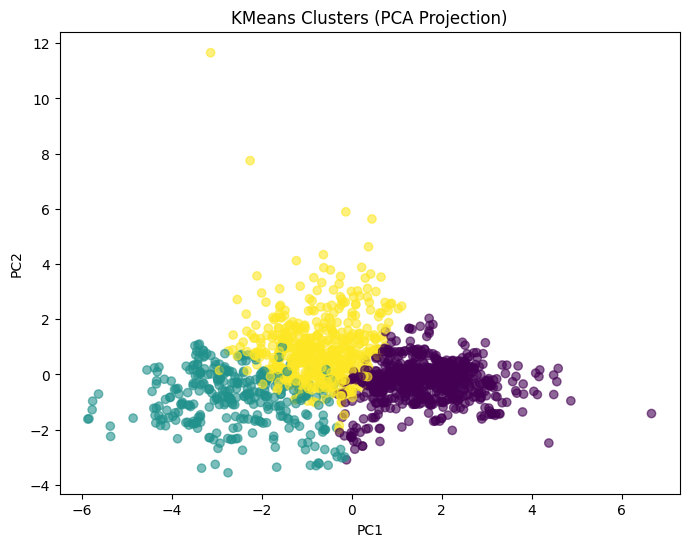

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=kmeans.labels_,
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters (PCA Projection)")
plt.show()

What is this graph we're looking at?

What we're seeing is a visual 2D representation of all 6 of our features. PCA (Principal Component Analysis) has reduced the dimensionality of the dataset from 6 dimensions down to 2, while trying to retain as much of the original variation as possible. Each point on this plot represents a planet, positioned according to its values along the first two principal components, which are combinations of the original features.

The colors (or clusters) indicate the groups that KMeans has identified. Even though we started with 6 features, PCA allows us to see patterns, similarities, and differences in the data in a simpler 2D space. Essentially, this graph is our "map" of how the planets are grouped based on their characteristics.

In [21]:
# In order to make the data more human readable...
centroids_scaled = kmeans.cluster_centers_

In [22]:
# Inverse transform using the scaler
centroids_original = scaler.inverse_transform(centroids_scaled)

In [23]:
centroids_df = pd.DataFrame(centroids_original, columns=features_for_scale)
centroids_df['cluster'] = range(len(centroids_df))

In [24]:
centroids_pca = pca.transform(centroids_scaled)
centroids_df['pca1'] = centroids_pca[:, 0]
centroids_df['pca2'] = centroids_pca[:, 1]

In [25]:
# Our "Planet level" DataFrame
planet_df = pd.DataFrame(X_pca, columns=['pca1', 'pca2'])
planet_df['cluster'] = main_df['cluster'].values  # cluster labels
planet_df['pl_name'] = main_df['pl_name'].values  # planet names

# let's add in original numeric features
for col in features_for_scale:
    planet_df[col] = main_df[col].values

In [26]:
planet_df.head(2)

,pca1,pca2,cluster,pl_name,pl_rade,pl_bmasse,pl_orbper,pl_eqt,st_teff,st_rad
0,-3.644068,-1.731932,1,GJ 1214 b,0.985070,1.879465,0.457673,555.0,3026.0,-1.555897
1,0.585641,-1.448958,0,NGTS-10 b,2.603197,6.532550,-0.265406,1332.0,4600.0,-0.360970


In [27]:
# Let's save this as a csv to access in streamlit
planet_df.to_csv('../data/processed/planet_df.csv', index=False)

In [28]:
# Adding in a better understanding of the variance for each PCA axis
pca.explained_variance_ratio_

array([0.57582509, 0.21277006])

In [29]:
# X - 58% variance
# Y - 21% variance
# Next I want some feature loadings, to show what each axis deemed important
loadings = pd.DataFrame(
    pca.components_.T,
    index=features_for_scale,
    columns=["PCA1", "PCA2"]
)

In [30]:
loadings.abs().sort_values("PCA1", ascending=False)

,PCA1,PCA2
st_teff,0.449423,0.189881
st_rad,0.448103,0.227586
pl_rade,0.448008,0.124569
pl_eqt,0.435395,0.422931
pl_bmasse,0.433685,0.129136
pl_orbper,0.137332,0.837308


In [31]:
# PCA1 ~ Planet-Star System Scale / Energy ~ Increases when Host Stars are hotter and larger, 
# Planet are more massive and have higher temperatures
# PCA2 ~ Long orbital patterns / via distance, maybe these are our cooler planets

Next, I want to prepare a Radar graph for additional visualization

To do this, I'll need to scale once again using a MinMax scalar. Our star temperature is dominating the Radar graph currently.

In [32]:
from sklearn.preprocessing import MinMaxScaler

# Select numeric features for radar
features_for_radar = ["pl_rade", "pl_bmasse", "pl_orbper", "pl_eqt", "st_teff", "st_rad"]

# Keep planet names for dropdown
planet_radar = planet_df[["pl_name"] + features_for_radar].copy()

# MinMax scale numeric features
radar_scaler = MinMaxScaler()
planet_radar[features_for_radar] = radar_scaler.fit_transform(planet_radar[features_for_radar])

# Save to CSV
planet_radar.to_csv("../data/processed/planet_df_radar.csv", index=False)


# What has been done up to this point? 

Initially, this project began as an exploration of the data that NASA has to offer for known exoplanets.

First, a viable data source was identified, documentation read, and brought into our project via a TAP API.

Once data was brought in, EDA was performed. NA records were removed.

A KMeans model was built to see if we could identify structure in our data set. What clusters could exist here? What do they tell us?

This was refined by some trial and error.

The structure was visualized for a user to interact with on streamlit.

Next, I would like to add Earth as a reference for our Radar graph. 

In order to do this, I'll need to use the exact same transformation steps that were used for all of the exoplanet data prior. 

Process was:

Take log of: pl_rade, pl_bmasse, pl_orbper, st_rad

Scale using the same standard scalar instance

Scale again using the same MinMaxScalar instance

In [33]:
# Create our Earth :)
earth_df = pd.DataFrame({
    "pl_name": ["Earth"],
    "pl_rade": [1.0],       
    "pl_bmasse": [1.0],    
    "pl_orbper": [365.25], 
    "pl_eqt": [288],       
    "st_teff": [5778],      
    "st_rad": [1.0]         
})

In [34]:
log_cols = ["pl_rade", "pl_bmasse", "pl_orbper", "st_rad"]
for col in log_cols:
    earth_df[col] = np.log(earth_df[col])

In [35]:
# scale using same standard scalar instance
earth_scaled = scaler.transform(earth_df[features_for_scale])
earth_df[features_for_scale] = earth_scaled

In [36]:
earth_df

,pl_name,pl_rade,pl_bmasse,pl_orbper,pl_eqt,st_teff,st_rad
0,Earth,-1.906426,-1.982282,3.195395,-1.598806,0.440496,0.067033


In [37]:
# now apply the MinMaxScalar instance
earth_df[features_for_radar] = radar_scaler.transform(earth_df[features_for_radar])

In [38]:
earth_df

,pl_name,pl_rade,pl_bmasse,pl_orbper,pl_eqt,st_teff,st_rad
0,Earth,-0.146906,0.058306,0.228154,-0.032176,-0.295485,0.712823


In [39]:
planet_radar.head(1)

,pl_name,pl_rade,pl_bmasse,pl_orbper,pl_eqt,st_teff,st_rad
0,GJ 1214 b,0.431339,0.390904,0.100986,0.109622,0.089936,0.45003
